In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [72]:
df = pd.DataFrame(dict(np.load('../psy-work/decision/result.npz')))

In all trials the network is given 0.5s to settle for a winner and it is supposed to output the winner for another 0.5s.

# Fraction of correct trials

A trial is considered correct if the largest input dimensions wins for all time points t > 0.5s and if the mean output of that dimension is at least 0.1.

The drift diffusion network requires a certain minimum input > 0.15 to decide for the winner within the time limit (baseline=0.1, target_sep=0.05 gets 0 correct trials). This minimum input can be reduced by scaling the input, but it is a trade-off as with increased input scale, noise on the input becomes more of an issue (performance degrades with increased baseline for less noise). The Usher-McClelland network is mostly independent of the baseline, but handles noise not at as well (at least for baseline <= 0.5).

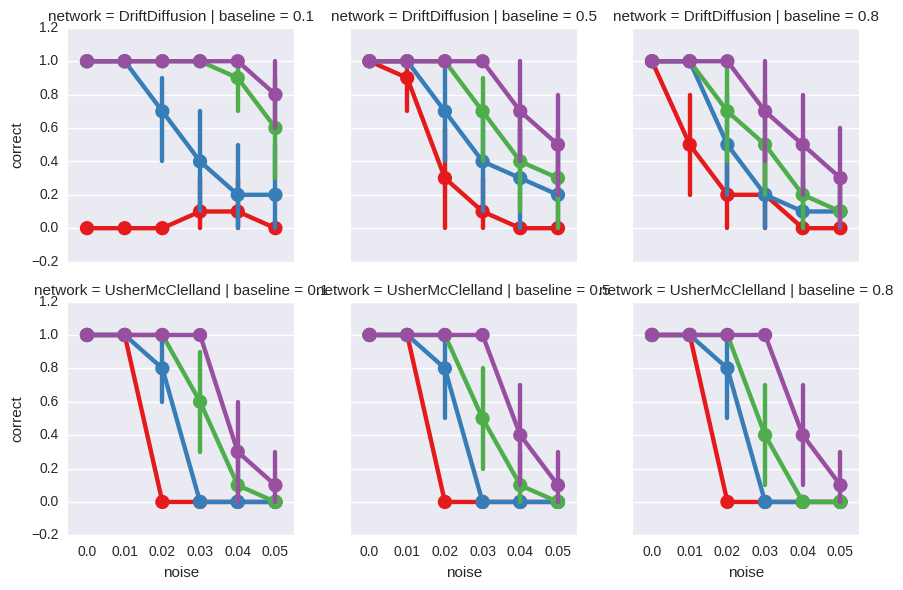

In [74]:
g = sns.FacetGrid(df, row='network', col='baseline')
g.map(sns.pointplot, 'noise', 'correct', 'target_sep', palette='Set1')

# Error on winner output

Here we measure how much the winner deviates from 1 in the mean (including the winner from incorrect trials). The idea is that it is better to get a clear decision for an item than being stuck without a decision due to noise. The drift diffusion network is doing perfectly as long as the input is large enough to reach the threshold in time (baseline >= 0.5). For smaller inputs the threshold might no be reached and were getting a negative error. With more time for the decision these should also reach the threshold and would than give a 0 error.

The Usher-McClelland network is again independent of the baseline, but in most cases produces outputs that are either too large or too small depending on the noise on target_sep. While we can threshold too large values, too small values might be more of an issue when integrating the network in a larger model.

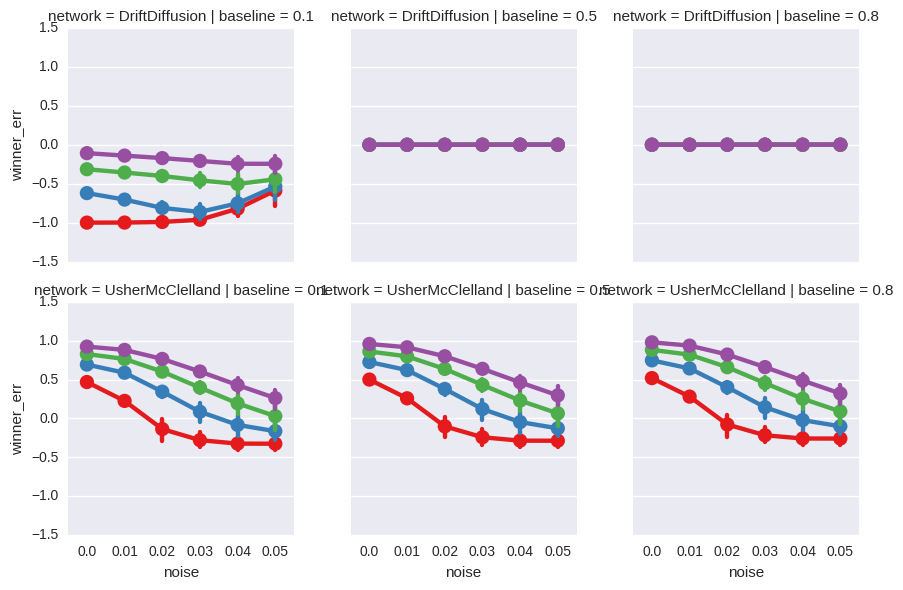

In [75]:
g = sns.FacetGrid(df, row='network', col='baseline')
g.map(sns.pointplot, 'noise', 'winner_err', 'target_sep', palette='Set1')

# Runner up error

Not only the output value of the winner is important, but also the mean value of the 2nd place ("runner up"). This value should ideally be 0 the get a perfect separation. This is what we find for the drift diffusion network (which errs in favour of not producing an output). With the Usher-McClelland network, however, the separation degrades and the value of the runner up seems to asymptotically approach 0.5.

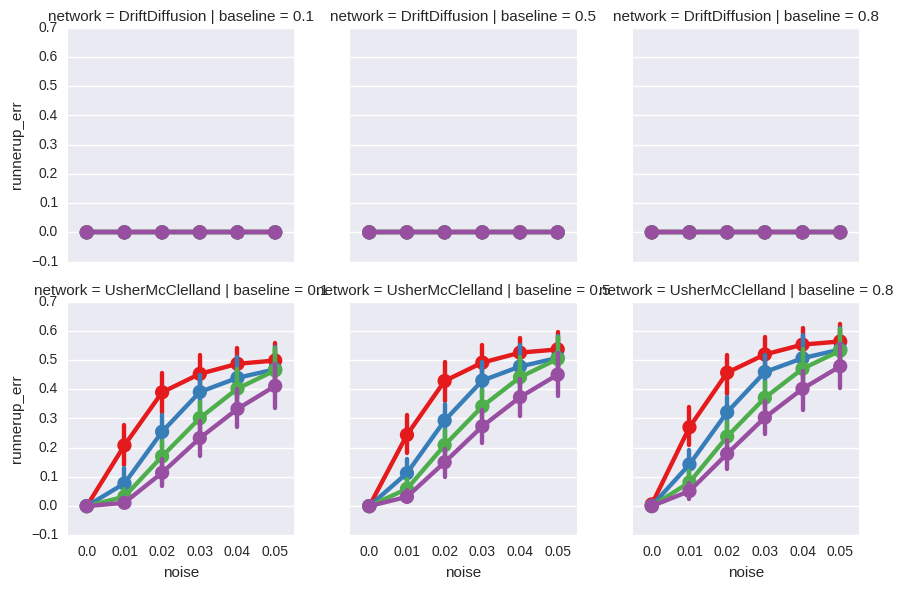

In [76]:
g = sns.FacetGrid(df, row='network', col='baseline')
g.map(sns.pointplot, 'noise', 'runnerup_err', 'target_sep', palette='Set1')

# Highest runner up error (transient response)

So far we only looked at the final output, but the output until a decision is made matters to. Ideally, the runner-up will never be above 0 in this time. The drift diffusion network is close to this behaviour. For larger baselines with some noise, we can get some runner-up activity, but it stays low. In contrast, the Usher-McClelland network produces large transient responses when noise is present.

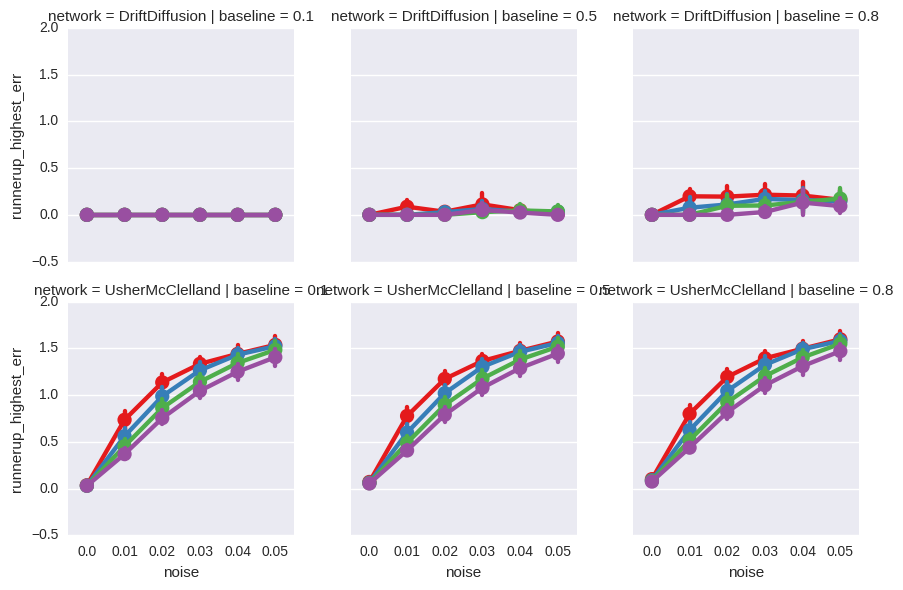

In [77]:
g = sns.FacetGrid(df, row='network', col='baseline')
g.map(sns.pointplot, 'noise', 'runnerup_highest_err', 'target_sep', palette='Set1')